In [5]:
from random import random
from math import sqrt, log,  exp
import matplotlib.pyplot as plt

In [111]:
from numba import njit

@njit(fastmath=True)
def box_muller_rand():
    while True:
        x = random() * 2.0 - 1
        y = random() * 2.0 - 1
        d = x * x + y * y 
        if d < 1:
            return x * sqrt(-2 * log(d) / d)

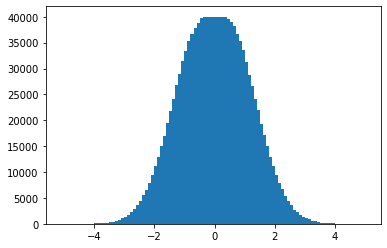

In [8]:
bins = { }
for i in range(1000000):
    num = round(box_muller_rand(), 1)
    bins[num] = bins.get(num, 0) + 1

plt.bar(bins.keys(), bins.values())
plt.show()

In [125]:
from numpy.random import normal
import numpy

def create_path(initial, time, steps, volatility, riskfree):
    dt = time / steps
    sdt = sqrt(dt)
    drift = exp((riskfree - 0.5 * volatility * volatility) * dt)

    norm_values = numpy.exp(normal(size=steps) * volatility * sdt) * drift
    path = numpy.zeros(steps)
    current = initial
    for i in range(steps):
        path[i] = current
        current = current * norm_values[i]

    return path

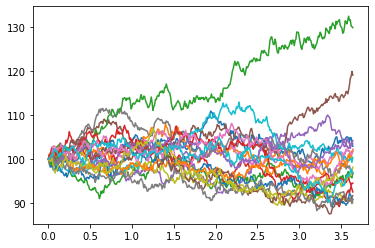

In [10]:
paths = []
x = [x / 100 for x in range(365)]
for i in range(20):
    paths.append(create_path(100, 1, 365, 0.1, 0.01))
    plt.plot(x, paths[-1])

In [123]:
def price_option(strike, spot, time, volatility, risk_free, call_or_put='c', knockin=None, knockout=None, simulations=2000, steps_per_unit = 365):
    if knockin and knockout:
        raise Exception("Unable to cope with 2 barriers!")

    cp = 1 if call_or_put == 'c' else -1

    premiums = []
    for i in range(simulations):
        path = create_path(spot, time, time * steps_per_unit, volatility, risk_free)
        if knockin and knockin > spot and max(path) < knockin: # Up and In
            premiums.append(0)
        elif knockin and knockin < spot and min(path) > knockin: # Down and In
            premiums.append(0)
        elif knockout and knockout < spot and min(path) < knockin: # Down and Out
            premiums.append(0)
        elif knockout and knockout > spot and max(path) > knockout: # Up and Out
            premiums.append(0)
        else:
            premiums.append(max(0, cp * (path[-1] - strike)))

    return sum(premiums) / simulations * exp(-time * risk_free)

In [126]:
spot=100
strike=105
vol=0.2
risk_free=0.05
price_option(strike, spot, 1, vol, risk_free, simulations=50000)


8.089799479699202

In [75]:
sim_tests = [100,200,500,1000,2000,5000,10000,20000,50000]
sim_out = {}
for sim in sim_tests:
    results = []
    for i in range(20):
        results.append(price_option(strike, spot, 1, vol, risk_free, simulations=sim))
    sim_out[sim] = {
        'min': min(results),
        'max': max(results),
        'mean': sum(results) / 20
    }
sim_out

{20000: {'min': 7.830023543668947,
  'max': 8.198467687906678,
  'mean': 8.011391595546261},
 50000: {'min': 7.88287244842448,
  'max': 8.133164154341774,
  'mean': 7.991736385861546}}

In [144]:
from numpy.random import normal
from numba import njit, prange

@njit(fastmath=True)
def path_final_min_max(initial, time, steps, volatility, riskfree):
    dt = time / steps
    sdt = sqrt(dt)
    drift = exp((riskfree - 0.5 * volatility * volatility) * dt)

    current = initial
    min = current
    max = current
    for i in range(steps - 1):
        current = current * drift * exp(sdt * volatility * box_muller_rand())
        if min > current:
            min = current
        if max < current:
            max = current

    return current, min, max

@njit
def payoff(cp, strike, spot, knockin, knockout, final, minimum, maximum):
    if knockin and knockin > spot and maximum < knockin: # Up and In
        return 0
    if knockin and knockin < spot and minimum > knockin: # Down and In
        return 0
    if knockout and knockout < spot and minimum < knockin: # Down and Out
        return 0
    if knockout and knockout > spot and maximum > knockout: # Up and Out
        return 0
    return max(0, cp * (final - strike))

@njit(parallel=True)
def price_option_2(strike, spot, time, volatility, risk_free, call_or_put='c', knockin=0, knockout=0, simulations=2000, steps_per_unit = 365):
    if knockin and knockout:
        raise Exception("Unable to cope with 2 barriers!")

    cp = 1 if call_or_put == 'c' else -1

    total = 0
    for i in prange(simulations):
        final, minimum, maximum = path_final_min_max(spot, time, time * steps_per_unit, volatility, risk_free)
        total += payoff(cp, strike, spot, knockin, knockout, final, minimum, maximum)

    return total / simulations * exp(-time * risk_free)

price_option_2(strike, spot, 1, vol, risk_free, simulations=50000)

8.112524570936278

In [1]:
import numpy
from numpy.random import normal


In [20]:
steps = 365
initial = 100
volatility = 0.2
sdt = sqrt(1/365)
drift = exp((0.05 - 0.5 * volatility * volatility) / 365)

randoms = numpy.exp(normal(size=steps)*volatility*sdt) * drift
randoms[0] = 1
factors = numpy.cumprod(randoms)
factors[-1], numpy.min(factors), numpy.max(factors)


(0.9667214716310903, 0.8827590844214009, 1.0228309838873972)